In [1]:
%load_ext autoreload

In [2]:
import pandas as pd
import re
from rdkit import Chem
from rdkit.Chem import Draw
import seaborn as sns
from regression_shap_mmp.ccrlib_master.utils_mmp import get_potency
import cairosvg
sns.set_theme(style="whitegrid")
%autoreload 2

In [3]:
results_path = './regression_shap_mmp/ECFP4/regression/'

In [4]:
mmp_path = "./ccrlib_master/"
df_mmp = pd.read_csv(mmp_path + "df_mmp_final_top10.csv")
df_mmp

,core,as,sub_1,cid_1,sub_2,cid_2,tid,mmp_id,dpot,similarity,mmp_trial
0,COc1cc(Nc2ncnc3cc([*:1])sc23)cc(OC)c1OC,253,c1ccc([*:1])cc1,CHEMBL4541014,Brc1ccc([*:1])cc1,CHEMBL4572443,203,0,1.151490,0.800000,0
1,COc1cc(Nc2ncnc3cc([*:1])sc23)cc(OC)c1OC,253,Ic1ccc([*:1])cc1,CHEMBL4473768,COc1ccc([*:1])cc1,CHEMBL4546122,203,1,0.716003,0.820000,0
2,COc1cc(Nc2ncnc3cc([*:1])sc23)cc(OC)c1OC,253,c1csc([*:1])c1,CHEMBL4460381,Clc1ccc([*:1])cc1,CHEMBL4552482,203,2,2.038223,0.685185,0
3,COc1cc2ncnc(N3CCCc4ccccc43)c2cc1NC(=O)C=CC[*:1],135,CN(C)[*:1],CHEMBL4176787,CC[*:1],CHEMBL4162530,203,3,0.338819,0.814286,0
4,Clc1cc(Nc2ncnc3cccc(O[*:1])c23)ccc1OCc1ccccn1,207,C[*:1],CHEMBL194389,C1CC([*:1])CCO1,CHEMBL193578,203,4,0.736759,0.718750,0
...,...,...,...,...,...,...,...,...,...,...,...
45337,O=c1cc(-c2[nH]c([*:1])nc2-c2ccc(F)cc2)cc[nH]1,3,O=C(O)c1ccc([*:1])cc1,CHEMBL3313935,C#Cc1ccc([*:1])cc1,CHEMBL3314276,260,475,0.504318,0.692308,9
45338,Nc1ccccc1Nc1ccc2c(c1)CCc1ccc(O[*:1])cc1C2=O,73,OCC(O)C[*:1],CHEMBL2152936_CHEMBL2152938,C[*:1],CHEMBL2152777,260,476,1.364568,0.677966,9
45339,O=C1NCc2c(-c3ccccc3Cl)nc(O[*:1])nc2N1c1c(Cl)cc...,144,CN(C)CC[*:1],CHEMBL211426,[*:1],CHEMBL213846,260,477,0.021189,0.616667,9
45340,O=C1c2ccc(Nc3ccccc3)cc2CCc2ccc(O[*:1])cc21,200,C[*:1],CHEMBL2152784,[*:1],CHEMBL2152796,260,478,0.162727,0.673913,9


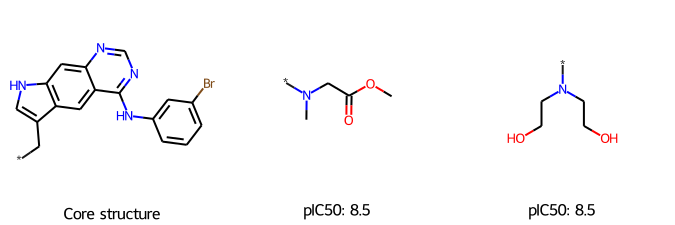

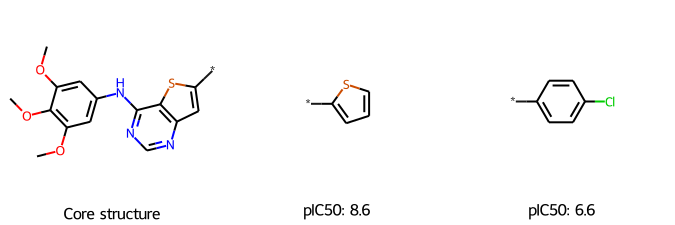

In [7]:
tid = 203
save = False
chembl_high_conf = pd.read_csv("./dataset/chembl_33_pIC50.csv")
for mmp in ['mmp', 'mmp-cliff']:
    if mmp == 'mmp':   
        df_mmp_mol = df_mmp.query(f'dpot < 0.1 and tid == @tid')
    else:    
        df_mmp_mol = df_mmp.query(f'dpot > 2 and tid == @tid')
        
    pic50 = "pIC50"
    df_mmp_mol = df_mmp_mol.copy()
    df_mmp_mol['core_n'] = 'Core structure'
    df_mmp_mol['core'] = df_mmp_mol.core.apply(lambda x: re.sub(r"\[\*:\d+\]", "*",x))
    df_mmp_mol['sub_1'] = df_mmp_mol.sub_1.apply(lambda x: re.sub(r"\[\*:\d+\]", "*",x))
    df_mmp_mol['sub_2'] = df_mmp_mol.sub_2.apply(lambda x: re.sub(r"\[\*:\d+\]", "*",x))
    df_mmp_mol['core'] = df_mmp_mol.core.apply(lambda x: Chem.MolFromSmiles(x))
    df_mmp_mol['sub_1'] = df_mmp_mol.sub_1.apply(lambda x: Chem.MolFromSmiles(x))
    df_mmp_mol['sub_2'] = df_mmp_mol.sub_2.apply(lambda x: Chem.MolFromSmiles(x))
    df_mmp_mol['pot_cid_1'] = df_mmp_mol.cid_1.apply(lambda x: f"pIC50: {round(get_potency(chembl_high_conf, x, tid),1)}")
    df_mmp_mol['pot_cid_2'] = df_mmp_mol.cid_2.apply(lambda x: f"pIC50: {round(get_potency(chembl_high_conf, x, tid),1)}")

    for i, mmp in enumerate(df_mmp_mol.to_dict('records')[:1]):
        core_sub = [mmp.get(key) for key in ['core', 'sub_1', 'sub_2']]
    legend = [f'{mmp.get(key)}' for key in ['core_n', 'pot_cid_1', 'pot_cid_2']]
    from rdkit.Chem.Draw import rdMolDraw2D
    dopts = rdMolDraw2D.MolDrawOptions()
    dopts.prepareMolsForDrawing = True
    dopts.updateAtomPalette({16:(.8,.3,0)}) #(.7,0,.7)
    dopts.baseFontSize = 0.8
    img = Draw.MolsToGridImage(core_sub, legends=legend, subImgSize=(225,225), drawOptions=dopts, molsPerRow=3, useSVG=True)
    display(img)
    if save:
        file_path = f'./f1/{tid}_nac_{i}.svg'
        with open(file_path, 'w') as f:
            f.write(img.data)
        cairosvg.svg2png( url=file_path, write_to= f'./f1/{tid}_nac_{i}.png', scale=3)
        del img